## imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import numpy as np

## data loading

Found 5000 files belonging to 1 classes.
(4500, 180, 180, 3)
(4500,)
<class 'tensorflow.python.framework.ops.EagerTensor'>


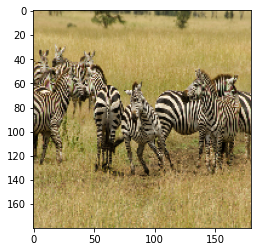

In [2]:
dataset_url = "http://images.cocodataset.org/zips/val2017.zip"
data_dir = tf.keras.utils.get_file(
    origin=dataset_url, fname="flower_photos", extract= True,cache_subdir="/content/sample_data/flower",archive_format='auto'
    )

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/sample_data/flower/", image_size=(180, 180), batch_size=4500 ,seed=420
    )

data_train = []
for data, labels in dataset.take(1):
    print(data.shape)
    print(labels.shape)
    data_train = data[:]
plt.imshow(data_train[0]/255)
print(type(data_train))
x_train = data_train.numpy()[:int(4500 *0.9)]
x_test = data_train.numpy()[int(4500 *0.9):]

In [3]:
data_shape = x_train.shape
size_x = data_shape[1]
size_y = data_shape[2]
if len(data_shape)==4:
  size_diamention = data_shape[3]
else:
  size_diamention = 1
print(data_shape)

(4050, 180, 180, 3)


## data normalization

In [4]:
x_train = x_train/255.0
x_test = x_test/255.0

## make training data with black box

(4050, 180, 180, 3)
(4050, 180, 180, 3)


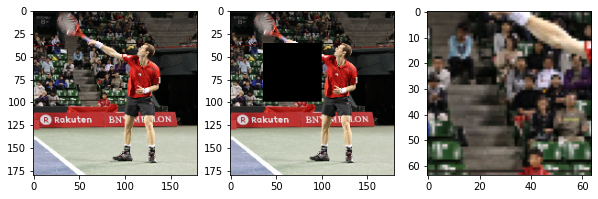

In [5]:
start_x_pos = 100-64
end_x_pos = 100
start_y_pos = 100-64
end_y_pos = 100

x_finle_size = end_x_pos - start_x_pos
y_finle_size = end_y_pos - start_y_pos

black_train = x_train.copy()
black_train[:,start_x_pos:end_x_pos,start_y_pos:end_y_pos,:] = 0

black_test = x_test.copy()
black_test[:,start_x_pos:end_x_pos,start_y_pos:end_y_pos,:] = 0

train_croped = x_train[:,start_x_pos:end_x_pos,start_y_pos:end_y_pos,:]
test_croped = x_test[:,start_x_pos:end_x_pos,start_y_pos:end_y_pos,:]

print(x_train.shape)
print(black_train.shape)

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(2, 3,1)
plt.imshow(x_train[1])

fig.add_subplot(2, 3,2)
plt.imshow(black_train[1])

fig.add_subplot(2, 3,3)
plt.imshow(train_croped[1])
plt.show()

## model creation

In [6]:
from os import name
ecoded_size = 1024
dropout_rate = 0.2
dropout_seed = 69

encoder_input = keras.Input(shape=(size_x,size_y,size_diamention), name = "img") # the input of the pictures

convolution1 = keras.layers.Conv2D(filters = 32,kernel_size = (3,3),activation="ELU", padding='same')(encoder_input)

pooling0 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)(convolution1)

convolution2 = keras.layers.Conv2D(filters = 64,kernel_size = (3,3),activation="ELU", padding='same')(pooling0)

pooling1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)(convolution2)

convolution3 = keras.layers.Conv2D(filters = 64,kernel_size = (3,3),activation="ELU", padding='same')(pooling1)

pooling2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)(convolution3)

convolution4 = keras.layers.Conv2D(filters = 128,kernel_size = (3,3),activation="ELU", padding='same')(pooling2)

pooling3 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)(convolution4)

convolution5 = keras.layers.Conv2D(filters = 128,kernel_size = (3,3),activation="ELU", padding='same')(pooling3)

pooling4 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)(convolution5)

convolution6 = keras.layers.Conv2D(filters = 256,kernel_size = (3,3),activation="ELU", padding='same')(pooling4)

pooling5 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)(convolution6)

flat = keras.layers.Flatten()(pooling5) # flatten the input

encoder_output = keras.layers.Dense(ecoded_size,activation="ELU",name="encoder_output")(flat) 

encoder = keras.Model(encoder_input,encoder_output) # connect encoder_input -> encoder_output

decoder_input = keras.layers.Dense(3072,activation="ELU")(encoder_output)

decoder_output = keras.layers.Reshape((int(x_finle_size/2),int(y_finle_size/2),size_diamention))(decoder_input)

convolution_decoder1 = keras.layers.Conv2D(filters = 256,kernel_size = (3,3),activation="ELU", padding='same')(decoder_output)

upsample1 = keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(convolution_decoder1)

convolution_decoder2 = keras.layers.Conv2D(filters = 4,kernel_size = (3,3),activation="ELU" , padding='same')(upsample1)

flat_out = keras.layers.Flatten(name="flattenForFullyConnected")(convolution_decoder2) 

dense_output = keras.layers.Dense(x_finle_size*y_finle_size*size_diamention,activation="ELU")(flat_out) 

reshape_output = keras.layers.Reshape((x_finle_size,y_finle_size,size_diamention))(dense_output) # reshape to output

opt = keras.optimizers.Adam(learning_rate=0.001,decay=1e-6)

autoencoder = keras.Model(encoder_input,reshape_output,name="autoencoder")
autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        

In [7]:
autoencoder.compile(opt,loss="mse")

## code for showing the training data over time

In [8]:
class Callback(keras.callbacks.Callback):
    def __init__(self, epochs,first_jump,figsize_x = 15,figsize_y = 70):
      self.epochs = epochs
      self.fig = plt.figure(figsize=(figsize_x, figsize_y))
      self.columns = 4
      self.rows = (epochs-first_jump) /3
      self.num = 1
    def show(self):
      plt.show()

    def on_epoch_end(self, epoch, logs=None):
      epoch+=1
      if(epoch>0 and epoch%3 == 0):
        ax = self.fig.add_subplot(self.rows, self.columns, self.num*4-3)
        ax.title.set_text(f'conjoined {epoch}')
        ae_out = autoencoder.predict([black_test[3].reshape(-1,size_x,size_y,size_diamention)])[0]
        conjoined = black_test[3].copy()
        conjoined[start_x_pos:end_x_pos,start_y_pos:end_y_pos,:] =  ae_out[:,:,:]
        plt.imshow(conjoined)

        ax = self.fig.add_subplot(self.rows, self.columns, self.num*4-2)
        ax.title.set_text(f'conjoined {epoch}')
        ae_out = autoencoder.predict([black_test[4].reshape(-1,size_x,size_y,size_diamention)])[0]
        conjoined = black_test[4].copy()
        conjoined[start_x_pos:end_x_pos,start_y_pos:end_y_pos,:] =  ae_out[:,:,:]
        plt.imshow(conjoined)

        ax = self.fig.add_subplot(self.rows, self.columns, self.num*4-1)
        ax.title.set_text(f'conjoined {epoch}')
        ae_out = autoencoder.predict([black_test[5].reshape(-1,size_x,size_y,size_diamention)])[0]
        conjoined = black_test[5].copy()
        conjoined[start_x_pos:end_x_pos,start_y_pos:end_y_pos,:] =  ae_out[:,:,:]
        plt.imshow(conjoined)

        ax4 = self.fig.add_subplot(self.rows, self.columns, self.num*4)
        example = encoder.predict([x_test[5].reshape(-1,size_x,size_y,size_diamention)])[0]
        ax4.title.set_text(f'encoded {epoch}')
        plt.imshow(example.reshape((int(ecoded_size/32)),int(32)),cmap="gray")
        self.num +=1


## training

In [9]:
epochs = 63
first_jump = 10
callback2 = Callback(epochs,first_jump)

history  = autoencoder.fit(black_train,train_croped,epochs=epochs,batch_size=64,validation_data=(black_test,test_croped))#),callbacks=[callback2])
# callback2.show()

Epoch 1/63
64/64 [==============================] - 32s 340ms/step - loss: 0.0904 - val_loss: 0.0544
Epoch 2/63
64/64 [==============================] - 20s 316ms/step - loss: 0.0517 - val_loss: 0.0508
Epoch 3/63
64/64 [==============================] - 20s 316ms/step - loss: 0.0476 - val_loss: 0.0463
Epoch 4/63
64/64 [==============================] - 21s 324ms/step - loss: 0.0441 - val_loss: 0.0424
Epoch 5/63
64/64 [==============================] - 20s 315ms/step - loss: 0.0430 - val_loss: 0.0425
Epoch 6/63
64/64 [==============================] - 20s 314ms/step - loss: 0.0418 - val_loss: 0.0428
Epoch 7/63
64/64 [==============================] - 20s 314ms/step - loss: 0.0403 - val_loss: 0.0407
Epoch 8/63
64/64 [==============================] - 20s 314ms/step - loss: 0.0384 - val_loss: 0.0432
Epoch 9/63
64/64 [==============================] - 20s 314ms/step - loss: 0.0375 - val_loss: 0.0437
Epoch 10/63
64/64 [==============================] - 20s 314ms/step - loss: 0.0365 - val_lo

<Figure size 1080x5040 with 0 Axes>

dict_keys(['loss', 'val_loss'])


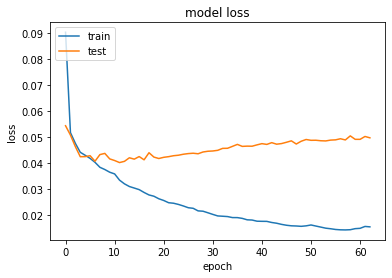

In [10]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
scores = autoencoder.evaluate(x_test, test_croped, verbose=0)
print('Accuracy: %.2f%% ' %(scores*100))

Accuracy: 9.30% 


## test the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


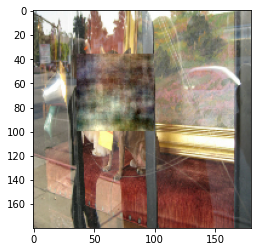

In [12]:

ae_out = autoencoder.predict([black_test[1].reshape(-1,size_x,size_y,size_diamention)])[0]
conjoined = black_test[1].copy()
conjoined[start_x_pos:end_x_pos,start_y_pos:end_y_pos,:] =  ae_out[:,:,:]
plt.imshow(conjoined)
# print(ae_out[:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

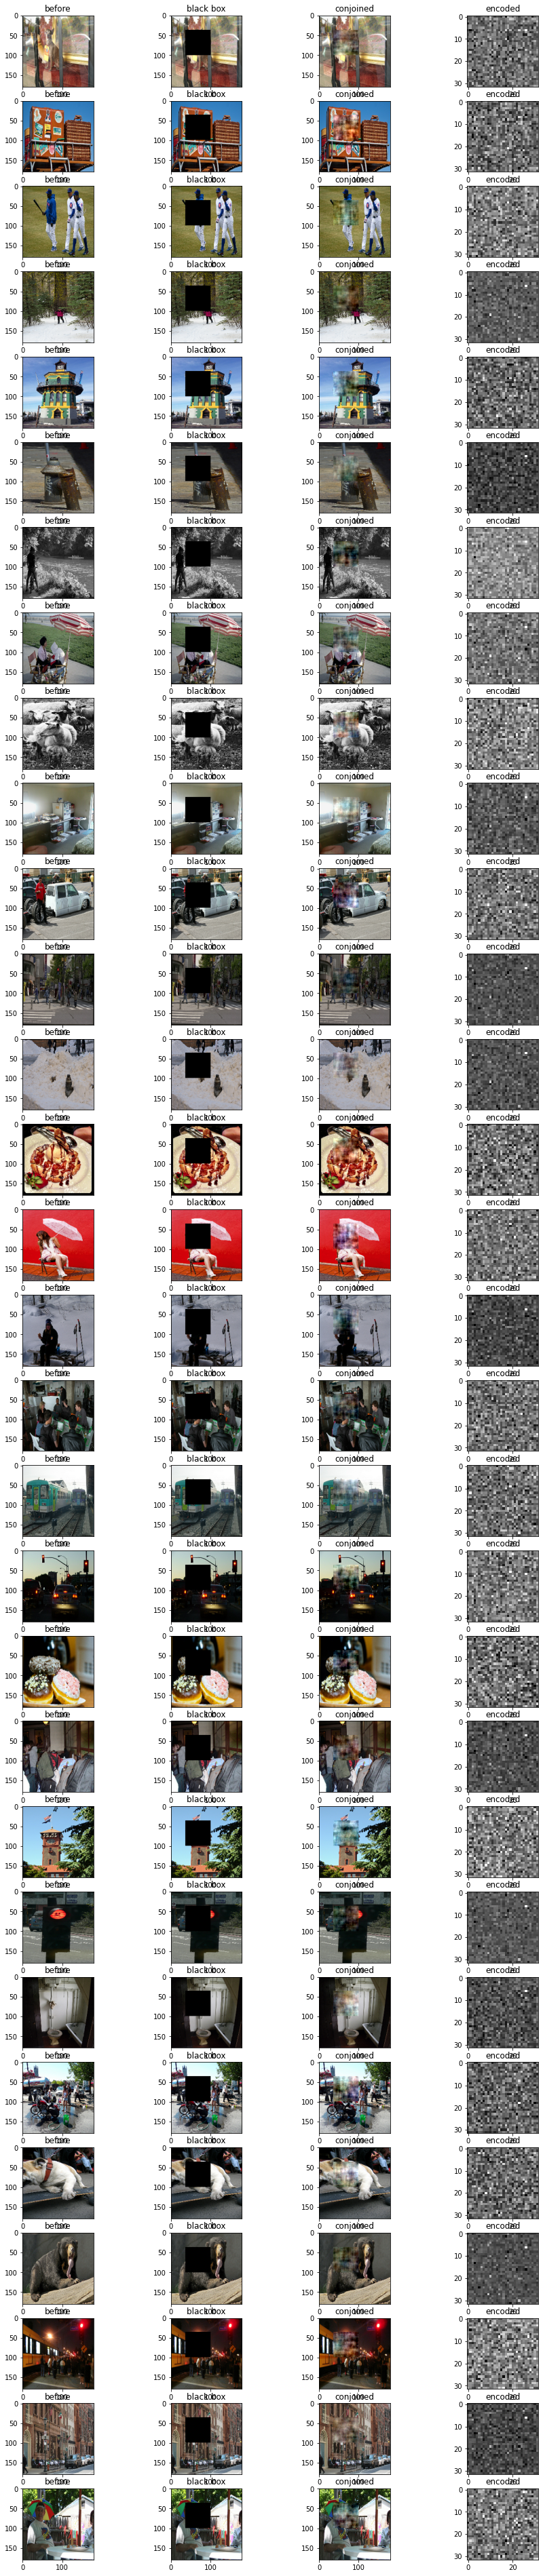

In [13]:
obj_num = 0


fig = plt.figure(figsize=(15, 69))
columns = 4
rows = 30
for i in range(1, int((columns*rows)/4) +1):
    ax1 = fig.add_subplot(rows, columns, i*4-3)
    ax1.title.set_text('before')
    plt.imshow(x_test[obj_num+i])

    ax2 = fig.add_subplot(rows, columns, i*4-2)
    ax2.title.set_text('black box')
    plt.imshow(black_test[obj_num+i])

    ax3 = fig.add_subplot(rows, columns, i*4-1)
    ax3.title.set_text('conjoined')
    ae_out = autoencoder.predict([black_test[obj_num+i].reshape(-1,size_x,size_y,size_diamention)])[0]
    conjoined = black_test[obj_num+i].copy()
    conjoined[start_x_pos:end_x_pos,start_y_pos:end_y_pos,:] =  ae_out[:,:,:]
    plt.imshow(conjoined)

    ax4 = fig.add_subplot(rows, columns, i*4)
    example = encoder.predict([x_test[obj_num+i].reshape(-1,size_x,size_y,size_diamention)])[0]
    ax4.title.set_text('encoded')
    plt.imshow(example.reshape((int(ecoded_size/32)),int(32)),cmap="gray")
plt.show()

save the model

In [14]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# autoencoder.save('./')